# Functional API 사용하여 CNN 모델 구성 및  MINST 분류하기

+ 본과정에서는 Functional API 사용하여 Convolution Neuron Network 모델링 해 보겠습니다.
+ 기존 Sequentail 모델로는 여러 개의 입력, 여러 개의 출력등을 구현하기 어렵기 때문에
+ 여러개 입력과 출력이 되는 복잡한 모델을 구성하려면 반드시 Functional API 사용해야 합니다.
+ 이전 강의와 똑같이 MNIST 데이터를 사용하고 CNN 모델을 Functional API로 모델링하도록 하겠습니다.
+ 추가로, Functional API 활용해서 중간 컨볼루션 레이어의 Feature Map 결과값을 이미지로 보여 주는 모델을 만들어 보겠습니다.

- 참고 사이트 : Functional API
> https://keras.io/guides/functional_api/ <br>
> https://wikidocs.net/38861

### 학습목차
1. Import modules
2. 데이터 불러오기 : Keras Dataset MNIST 활용
3. Functional API CNN 모델 구성
4. 모델 Compile : model.compile
5. 학습 수행 : model.fit , EarlyStopping , ModelCheckpoint
6. 학습 결과 테스트 : model.evaluate
7. 성능 그래프
8. 설전 테스트 : 손글씨 입력해서 분류 잘하는지 보기
9. 추가 : Functional API 활용해서 중간 컨볼루션 레이어의 Feature Map 결과값을 이미지로 보여주는 모델 생성

## 1. Import modules

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. 데이터 불러오기

In [2]:
# Keras MNIST 데이터셋 불러오기

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
# 3차원 배열
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
y_train.shape, y_test.shape

((60000,), (10000,))

## 3. Functional API CNN 모델 구성

#### <font color=blue>ㅇ CNN 입력 구조 : 4차원 : Batch * Height * Weidth * Channel</font>

In [5]:
# Model, Input 함수 추가
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input

In [7]:
# 28 X 28 shape를 CNN 모델에 입력으로 주기 위해 28 X 28 X 1 shape 변경 : 채널 추가
# x_train = x_train[..., tf.newaxis]
# x_test = x_test[..., tf.newaxis]

x_train = x_train.reshape(x_train.shape[0], 28, 28 ,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28 ,1)
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
# Sequential 모델하기
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same',
#                  activation='relu',
#                  input_shape=(28,28,1)))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# model.add(Conv2D(64,(2,2), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(10, activation='softmax'))

# Functional API 모델링하기
inputs = Input(shape=(28, 28, 1))
conv1 = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(inputs)  # 28 X 28 X 32
pool1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)  # 14 X 14 X 32

conv2 = Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu')(pool1)  # 14 X 14 X 64
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)  # 7 X 7 X 64
drop2 = Dropout(0.2)(pool2)

flat3 = Flatten()(drop2)  # 3136

dense4 = Dense(units=128, activation='relu')(flat3)
drop4 = Dropout(0.3)(dense4)
outputs = Dense(10, activation='softmax')(drop4)

model = Model(inputs=inputs, outputs=outputs)

## 4. 모델 Compile

In [9]:
# Y 레이블 원핫인코딩 하지 않기

# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train, num_classes=10)
# y_test = to_categorical(y_test, num_classes=10)

In [10]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [12]:
# Y 레이블 원핫인코딩 내부적으로 수행하도록 loss = 'sparse_categorical_crossentropy' 설정

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0     

## 5. 학습 수행

In [13]:
EPOCHS = 5
BATCH_SIZE = 1024

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
es = EarlyStopping(monitor='val_loss', patience=4, mode='min', verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [16]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es, mc], validation_data=(x_test, y_test))

Epoch 1/5
59/59 [==============================] - ETA: 0s - loss: 0.7322 - accuracy: 0.7800
Epoch 1: val_accuracy improved from -inf to 0.94050, saving model to best_model.h5
59/59 [==============================] - 14s 36ms/step - loss: 0.7322 - accuracy: 0.7800 - val_loss: 0.1933 - val_accuracy: 0.9405
Epoch 2/5
 4/59 [=>............................] - ETA: 1s - loss: 0.2545 - accuracy: 0.9224

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/59 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9462
Epoch 2: val_accuracy improved from 0.94050 to 0.97160, saving model to best_model.h5
59/59 [==============================] - 1s 25ms/step - loss: 0.1800 - accuracy: 0.9463 - val_loss: 0.0887 - val_accuracy: 0.9716
Epoch 3/5
58/59 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.9676
Epoch 3: val_accuracy improved from 0.97160 to 0.98180, saving model to best_model.h5
59/59 [==============================] - 1s 25ms/step - loss: 0.1099 - accuracy: 0.9677 - val_loss: 0.0588 - val_accuracy: 0.9818
Epoch 4/5
58/59 [============================>.] - ETA: 0s - loss: 0.0829 - accuracy: 0.9748
Epoch 4: val_accuracy improved from 0.98180 to 0.98480, saving model to best_model.h5
59/59 [==============================] - 1s 24ms/step - loss: 0.0828 - accuracy: 0.9748 - val_loss: 0.0470 - val_accuracy: 0.9848
Epoch 5/5
57/59 [===========================>..] - ETA: 0s - loss: 0.0681 - accurac

## 6. 학습 결과 테스트

In [17]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0439 - accuracy: 0.9851


[0.043872684240341187, 0.9850999712944031]

## 7. 성능 그래프

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
x_range = range(1,len(history.history['accuracy'])+1)

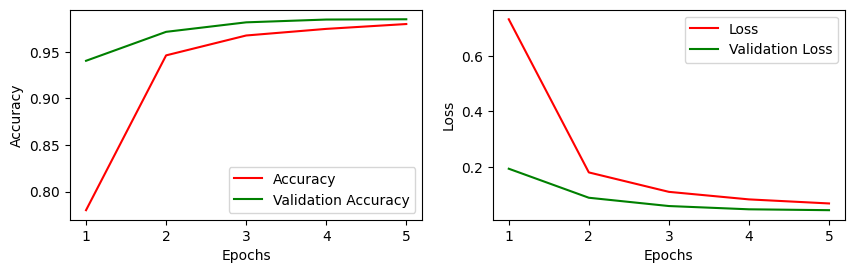

In [20]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(x_range, history.history['accuracy'], color='red', label='Accuracy')
plt.plot(x_range, history.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(222)
plt.plot(x_range, history.history['loss'], color='red', label='Loss')
plt.plot(x_range, history.history['val_loss'], color='green', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## 8. 실전 테스트

In [21]:
x_test[0].shape

(28, 28, 1)

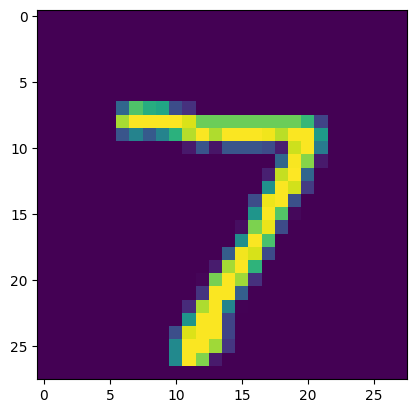

1/1 [==============================] - 0s 119ms/step
Prediction Probability:  [[1.5207522e-07 4.4980692e-07 5.6773119e-06 1.6549059e-06 3.1787097e-09
  1.5354043e-08 7.9195218e-12 9.9998963e-01 5.3630448e-08 2.3125488e-06]]
The Answer is  [7]


In [22]:
n = 0
plt.imshow(x_test[n].reshape(28,28))
plt.show()

pred = model.predict(x_test[n].reshape(1,28,28,1))
answer = np.argmax(pred, axis=-1)

print('Prediction Probability: ', pred)
print('The Answer is ', answer)

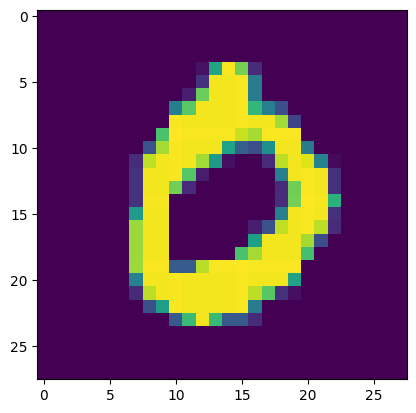

1/1 [==============================] - 0s 19ms/step
Prediction Probability:  [[9.99973536e-01 1.61364113e-07 2.18641230e-06 1.37201411e-07
  4.00030160e-08 1.15417684e-07 1.60129312e-05 6.46563922e-06
  1.88279913e-07 1.28996851e-06]]
The Answer is  [0]


In [23]:
n = 3
plt.imshow(x_test[n].reshape(28,28))
plt.show()

pred = model.predict(x_test[n].reshape(1,28,28,1))
answer = np.argmax(pred, axis=-1)

print('Prediction Probability: ', pred)
print('The Answer is ', answer)

## 9. 추가 : Functional API 활용해서 중간 컨볼루션 레이어의 Feature Map 결과값을 이미지로 보여주는 모델 생성

In [25]:
# 모델 레이아웃 확인
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0     

In [27]:
# Functional API 활용하여 중간의 컨볼루션 레이어의 Feature Map 이미지 출력하는 모델 만들기
# 1개 입력 : model.input
# 2개 출력 : conv2d, conv2d_1 레이어 output

conv2d_layer = model.get_layer('conv2d')
conv2d_1_layer = model.get_layer('conv2d_1')

# Functional API 이용해서 새로운 conv_model 모델 생성
# 이미 레이어별로 학습되어 있어 그냥 가져와 사용하여 됨. 다시 학습할 필요없음
conv_model = tf.keras.models.Model(
    inputs=[model.input],
    outputs=[conv2d_layer.output, conv2d_1_layer.output]
)

In [28]:
# train 데이터 1개를 입력하고 컨볼루션 2개의 Feature map 예측하기

sample = x_train[0][tf.newaxis, ...]  # 1 X 28 X 28 X 1
featuremap = conv_model.predict(sample)
len(featuremap)

1/1 [==============================] - 0s 62ms/step


2

In [30]:
# 결과값은 리스트로 되어 있게 2개 원소 구성
type(featuremap)

list

In [33]:
# 각 원소는 넘파이 어레이 임
type(featuremap[0])

numpy.ndarray

In [34]:
# 첫번째 컨볼루션 Feature Map 확인하기 : 32개 Feature map

conv_f1 = featuremap[0]
conv_f1.shape

(1, 28, 28, 32)

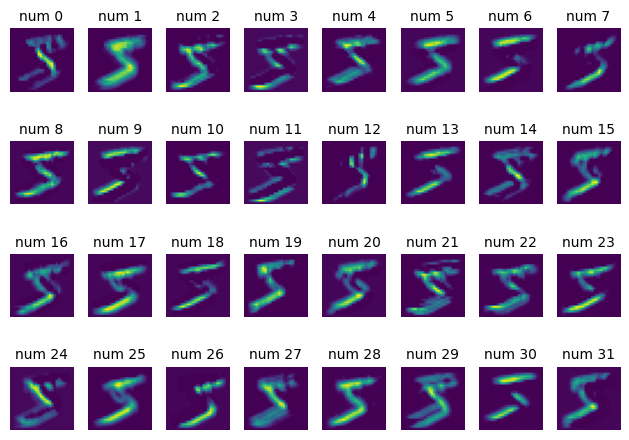

In [35]:
# 첫번째 컨볼루션의 32개의 Feature Map 결과값 이미지 보기

fig, axes = plt.subplots(4, 8)

for i in range(32):
  ax = axes[i//8, i%8]
  ax.imshow(conv_f1[0, :, :, i], cmap='viridis')
  ax.set_axis_off()
  ax.set_title(f'num {i}', fontsize=10)

plt.tight_layout()
plt.show()

In [36]:
# 두번째 컨볼루션 Feature Map 확인하기 : 64개 Feature map

conv_f2 = featuremap[1]
conv_f2.shape

(1, 14, 14, 64)

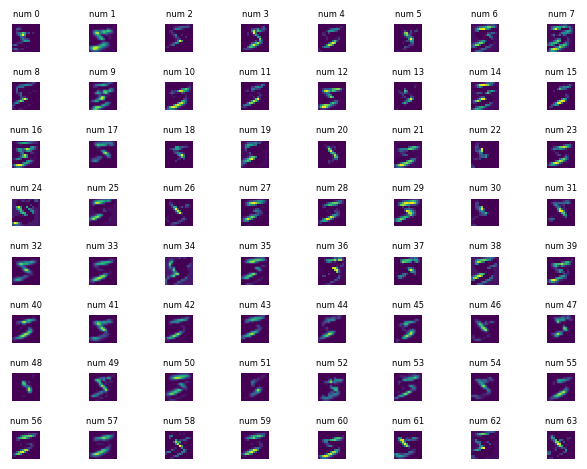

In [37]:
# 두번째 컨볼루션 64개의 Feature Map 결과값 이미지 보기

fig, axes = plt.subplots(8, 8)

for i in range(64):
  ax = axes[i//8, i%8]
  ax.imshow(conv_f2[0, :, :, i], cmap='viridis')
  ax.set_axis_off()
  ax.set_title(f'num {i}', fontsize=6)

plt.tight_layout()
plt.show()

## 배운 내용 정리
1. Functional API 사용하여 CNN 모델 구성
2. 기존 Sequences 모델로는 구성하기 어려운 여러 개의 입력과 여러 개의 출력을 구성할수 있는 Functional API를 사용해서 CNN 모델링 해 보았습니다.
3. 또한, 새로운 Functional API 모델를 만들어, CNN 모델의 Feature Map 이미지 확인해 보았습니다.   
2. 백문이 불여일타 : 반복 사용하여 익숙해 졌으면 좋겠네요.